# Introduction

This notebook explores different cost functions to mine union tripples from fuse.

In [131]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
import io
import tarfile
import pandas as pd
import numpy as np
from tqdm import tqdm

In [133]:
# Suppress warning for xlrd
import warnings
# Filter all warning that start with "WARNING"
warnings.filterwarnings('ignore')

In [134]:
# pass over all files and build summary
file = '/Users/dirkocoetsee/Downloads/fuse-binaries-dec2014.tar.gz'
# Get list of files in tar archive
tar = tarfile.open(file)

In [135]:
all_members = tar.getmembers()
len(all_members)

249377

In [137]:
from pickle import load
print('Loading')
with open('meta.pkl', 'rb') as f:
    vocab, words_member = load(f)
print('Adding')
words_member = [('cc-binaries/' + m, s) for m, s in words_member]
len(words_member), len(vocab)

Loading
Adding


(279699, 8591565)

In [148]:
if isinstance(words_member[0], tarfile.TarInfo):
    index_name_map = {i: k for i, k in enumerate(words_member)}
else:
    # Map back to filenames
    index_name_mapn = {i: k for i, k in enumerate(words_member)}
    # Map back to members
    member_name_map = {member.name: member for member in all_members}
    index_name_map = {i: (member_name_map[filek], sheetk) for i, (filek, sheetk) in index_name_mapn.items()}

In [154]:
k = 20

In [195]:
df = pd.read_parquet('ftripples.parquet')
df = df[df.score > 0]
df.shape

(553565, 10)

<Axes: >

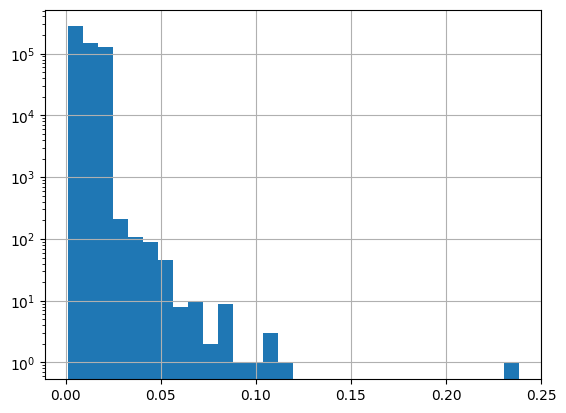

In [196]:
# Log
df.score.iloc[0:100_000_000].hist(bins=30, log=True)

In [197]:
import pandas as pd
from scipy.sparse import coo_matrix
from scipy.sparse.csgraph import connected_components

# Suppose df is your DataFrame with columns 'i', 'j', 'k'
# Create the three edge sets from each 3-clique
edges_ij = df[['i', 'j']]
edges_ik = df[['i', 'k']].rename(columns={'k': 'j'})
edges_jk = df[['j', 'k']].rename(columns={'j': 'i', 'k': 'j'})

# Concatenate all edges into one DataFrame
edges = pd.concat([edges_ij, edges_ik, edges_jk], ignore_index=True)
print('edges', edges.shape)

# For an undirected graph, ensure symmetry by adding the reversed pairs
edges_sym = pd.concat([edges, edges.rename(columns={'i': 'j', 'j': 'i'})], ignore_index=True)

# Extract row and column indices for the sparse matrix
rows = edges_sym['i']
cols = edges_sym['j']

# Determine the total number of nodes. Here we assume nodes are 0-indexed.
n_nodes = df[['i', 'j', 'k']].max().max() + 1
print('n_nodes', n_nodes)

# Build the sparse adjacency matrix
data = [1] * len(rows)
adjacency_matrix = coo_matrix((data, (rows, cols)), shape=(n_nodes, n_nodes))


edges (1660695, 2)
n_nodes 279664


In [198]:
# Compute the connected components
n_components, labels = connected_components(adjacency_matrix, directed=False)

print("Number of connected components:", n_components)
print("Component labels for each node:", labels)

Number of connected components: 262715
Component labels for each node: [     0      1      2 ... 262713 262714     88]


In [210]:
#[(i, j) for _, (i, j) in df[['i', 'j']].head(20).iterrows()]
#[(labels[i].item(), labels[j].item()) for _, (i, j) in df[['i', 'j']].head(20).iterrows()]
df['component'] = [labels[i].item() for i in df.i]

In [211]:
# Now get the highest scoring row per component
dfc = df.head(100).groupby('component').apply(lambda x: x.loc[x.score.idxmax()]).sort_values('score', ascending=False)
dfc.shape

(13, 11)

In [212]:
# Load and display
for _, (if1, if2, if3, score, *als) in dfc.iloc[:4].iterrows():
    f1 = (index_name_map[if1])
    f2 = (index_name_map[if2])
    f3 = (index_name_map[if3])
    for i, (f, s) in enumerate([f1, f2, f3]):
        buffer = tar.extractfile(f)
        df = pd.read_excel(io.BytesIO(buffer.read()), sheet_name=s, header=None, index_col=None, nrows=10)
        print(f'File {i}:{s} ({score}): {f}  {als}')
        print()
        # Display as html
        display(df)
        print()


File 0:0 (0.23817812022131174): <TarInfo 'cc-binaries/34b4af4e-68c1-4031-ad20-1b056bed0bb5' at 0x1570eb1c0>  [115.0, 69.0, 79.0, 274.0, 199.0, 197.0, 132.0]



,0,1,2,3,4
0,Код по НКПД 2011,Наименование по НКПД 2011,Код по НКПД 2005,Наименование по НКПД 2005,съвпадение
1,31547001,Авиодиспечер,31447001,Авиодиспечер,да
2,35223025,"Авиодиспечер, аеронавигационни съобщения",няма код,няма код,не
3,31543002,"Авиодиспечер, въздушно обслужване",31443002,"Авиодиспечер, въздушно обслужване",да
4,21446048,Авиоинженер,21496040,Авиоинженер,да
5,21126001,Авиометеоролог,21126001,Авиометеоролог,да
6,31553001,Авиомеханик,31453001,Авиомеханик,да
7,31553002,Авиомоторист,31453002,Авиомоторист,да
8,31553003,Авиотехник,31453003,Авиотехник,да
9,54123008,Автоконтрольор,34503001,Автоконтрольор,да



File 1:8 (0.23817812022131174): <TarInfo 'cc-binaries/136c6594-d14e-41f6-a1fb-2f581b66aa9f' at 0x4aeb41240>  [115.0, 69.0, 79.0, 274.0, 199.0, 197.0, 132.0]



,0,1
0,Код по НКПД 2011,Наименование по НКПД 2011
1,31547001,Авиодиспечер
2,35223025,"Авиодиспечер, аеронавигационни съобщения"
3,31543002,"Авиодиспечер, въздушно обслужване"
4,21446048,Авиоинженер
5,21126001,Авиометеоролог
6,31553001,Авиомеханик
7,31553002,Авиомоторист
8,31553003,Авиотехник
9,54123008,Автоконтрольор



File 2:6 (0.23817812022131174): <TarInfo 'cc-binaries/26c8bb06-0e49-4bd1-b447-a3c1ae19a087' at 0x4ae262440>  [115.0, 69.0, 79.0, 274.0, 199.0, 197.0, 132.0]



,0,1
0,Код по НКПД,Наименование
1,31447001,Авиодиспечер
2,31443002,"Авиодиспечер, въздушно обслужване"
3,21496040,Авиоинженер
4,22217078,Авиолекар
5,21126001,Авиометеоролог
6,31453001,Авиомеханик
7,31453002,Авиомоторист
8,31453003,Авиотехник
9,34503001,Автоконтрольор



File 0:0 (0.11230335926631886): <TarInfo 'cc-binaries/24654c3e-adfe-4688-8caf-55c6e3dbbaea' at 0x154b13c40>  [32.0, 35.0, 15.0, 198.0, 241.0, 328.0, 755.0]



,0,1
0,HA number,HA Name
1,AK901,AK HSG FINANCE CORP
2,AL001,HSG AUTH OF BIRMINGHAM DISTRICT
3,AL002,MOBILE HOUSING BOARD
4,AL005,HA PHENIX CITY
5,AL007,DOTHAN H/A
6,AL008,HA SELMA
7,AL047,HA HUNTSVILLE
8,AL048,HA DECATUR
9,AL049,HA GREATER GADSDEN



File 1:0 (0.11230335926631886): <TarInfo 'cc-binaries/0a33662a-fbd3-42de-981d-5646237e87d6' at 0x2fc652b00>  [32.0, 35.0, 15.0, 198.0, 241.0, 328.0, 755.0]



,0,1,2,3,4
0,HA Num,HA Name,FY 1997 - FY 2009 NED*,NED Category 2,Total NED
1,AK901,AK HSG FINANCE CORP,45,NaN,45
2,AL002,MOBILE HOUSING BOARD,122,NaN,122
3,AL006,H/A CITY OF MONTGOMERY,100,NaN,100
4,AL069,HA LEEDS,1,NaN,1
5,AL086,HA JEFFERSON COUNTY,175,NaN,175
6,AL129,HA WALKER COUNTY,34,NaN,34
7,AR131,JONESBORO URBAN RENEWAL & HSG AUTHORITY,100,NaN,100
8,AR161,CONWAY COUNTY HOUSING AUTH,125,NaN,125
9,AR197,WHITE RIVER REGIONAL HOUSING AUTHORITY,100,NaN,100



File 2:0 (0.11230335926631886): <TarInfo 'cc-binaries/6e58050b-9e39-4f65-a493-eed413fe2970' at 0x4af703940>  [32.0, 35.0, 15.0, 198.0, 241.0, 328.0, 755.0]



,0,1,2,3,4,5,6
0,HCV FSS household counts from 1/1/10 through 1...,NaN,NaN,NaN,NaN,NaN,NaN
1,HA State,HA Name,Formal HA Name,HA Code,FO Name,FO Code,Number of Households
2,Alabama,Birmingham,Housing Authority of the Birmingham District,AL001,Birmingham Hub Office,4CPH,43
3,Alabama,Mobile,Mobile Housing Board,AL002,Birmingham Hub Office,4CPH,160
4,Alabama,Montgomery,Housing Authority of the City of Montgomery,AL006,Birmingham Hub Office,4CPH,73
5,Alabama,Dothan,Housing Authority of the City of Dothan,AL007,Birmingham Hub Office,4CPH,13
6,Alabama,Selma,Selma Housing Authority,AL008,Birmingham Hub Office,4CPH,17
7,Alabama,Huntsville,The Housing Authority of the City of Huntsville,AL047,Birmingham Hub Office,4CPH,145
8,Alabama,Decatur,Housing Authority of the City of Decatur,AL048,Birmingham Hub Office,4CPH,38
9,Alabama,Florence,Florence H/A,AL054,Birmingham Hub Office,4CPH,28



File 0:1 (0.10693342094862127): <TarInfo 'cc-binaries/002f47b7-ac6c-4111-a0d5-f9e8931fafe1' at 0x4ad2c84c0>  [194.0, 11.0, 30.0, 332.0, 308.0, 380.0, 31882.0]



,0,1,2,3
0,"ספריה צבורית ע""ש צ'ייס מבשרת ציון",02-5332648,מבשרת ציון,"רח' החוצבים, מבשרת ציון 90805"
1,תיכון הראל,02-5333466,מבשרת ציון,החוצבים 6 מבשרת ציון
2,ספרית הר אדר,02-5334434,הר אדר,ת.ד. 33 הר אדר 90836
3,טומשין אבו גוש,02-5340296,אבו גוש,רח' השלום אבו גוש
4,חטיבת היובל מבשרת ציון,02-5341455,מבשרת ציון,רח' היסמין 5 מבשרת ציון 90805
5,"בי""ס דקל וילנאי",02-5352408,מעלה אדומים,דרך מדבר יהודה 1 מעלה אדומים ת.ד. 852
6,"עירונית השלום ע""ש בני ציון",02-5357108,מעלה אדומים,דרך מדבר יהודה 6 ת.ד.20 מעלה אדומים 98300
7,הספריה הציבורית גבעת זאב,02-5360140,גבעת זאב,גבעת זאב ת.ד. 902
8,אולפנה צביה ירושלים,02-5380771,ירושלים,רח' ירמיהו 5 ירושלים
9,הועד הישראלי לאונסקו,02-5603746,ירושלים,משרד החינוך ירושלים 91911



File 1:2 (0.10693342094862127): <TarInfo 'cc-binaries/002f47b7-ac6c-4111-a0d5-f9e8931fafe1' at 0x4ad2c84c0>  [194.0, 11.0, 30.0, 332.0, 308.0, 380.0, 31882.0]



,0,1,2,3
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,ישוב,שם ספריה,טלפון,כתובת
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,אבו גוש,תיכון טומשין אבו גוש,02-5340296,רח' השלום אבו גוש 90845
7,אלון שבות,אולפנה לבנות נוה-חנה,02-9931262,אלון שבות 90433
8,בית אל,ישיבה תיכונית מטה בנימין,02-9975864,בית אל ד.נ. מזרח בנימין 90631
9,בית שמש,"תיכון ""אמית"" בית שמש",02-991173,רח' עליית הנוער 2 בית שמש 99000



File 2:0 (0.10693342094862127): <TarInfo 'cc-binaries/002f47b7-ac6c-4111-a0d5-f9e8931fafe1' at 0x4ad2c84c0>  [194.0, 11.0, 30.0, 332.0, 308.0, 380.0, 31882.0]



,0,1,2,3
0,רשימת מנויי ספריה ציבורית,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,שם ספריה,טלפון,ישוב,כתובת
3,NaN,NaN,NaN,NaN
4,עירונית נצרת עילית,04-6560363,נצרת עילית,מעלה יצחק 4 נצרת עילית ת.ד. 1144
5,"ציבורית ע""ש אהרון ואלה טיכו",04-6380061,בנימינה,ת.ד. 68 בנימינה פינת נילי 62 30500
6,עירונית - יד שטרית,04-6739577,טבריה,ביאליק 13 ת.ד. 760 טבריה 14221
7,ספריה עירונית מעלות-תרשיחא,04-9979687,מעלות,הארזים 5 מעלות 24952
8,"ספריה ע""ש מאירהוף",08-9457916,רחובות,גולדין 6 רחובות 76107
9,ספריה עירונית ערד,08-9973335,ערד,"א. בן-יאיר 28 בנין המתנ""ס ערד 89021"



File 0:1 (0.1018434332602961): <TarInfo 'cc-binaries/356b42f5-2753-473a-9afe-99f2a96daf82' at 0x151a83f40>  [25.0, 19.0, 13.0, 114.0, 79.0, 642.0, 92.0]



,0,1,2
0,PlasmoDB ID,Interacts with,PlasmoDB ID
1,PF14_0647,pp,PF13_0036
2,PFI1335w,pp,PF08_0115
3,PFI0875w,pp,PFL0290w
4,PFI0875w,pp,PFI0875w
5,PFI0875w,pp,PF14_0613
6,PFI0875w,pp,PF14_0443
7,PFI0875w,pp,PF14_0197
8,PFI0875w,pp,PF13_0092
9,PFI0875w,pp,MAL13P1.56



File 1:0 (0.1018434332602961): <TarInfo 'cc-binaries/2279d284-bf59-4201-bdc4-571366a9b73d' at 0x4adbf1180>  [25.0, 19.0, 13.0, 114.0, 79.0, 642.0, 92.0]



,0,1,2,3,4
0,PF11_0168,NaN,NaN,NaN,pp shows interologs predicted interaction wher...
1,PFI0875w,pp,MAL8P1.17,NaN,NaN
2,PFI0875w,pp,MAL8P1.69,NaN,NaN
3,PFI0875w,pp,PF10_0084,NaN,NaN
4,PFI0875w,pp,PF11_0352,NaN,NaN
5,PFI0875w,pp,PF13_0214,NaN,NaN
6,PFI0875w,pp,PF13_0305,NaN,NaN
7,PFI0875w,pp,PFI0875w,NaN,NaN
8,PFI0875w,pp,PFL1070c,NaN,NaN
9,PFI0875w,py,MAL13P1.56,NaN,NaN



File 2:0 (0.1018434332602961): <TarInfo 'cc-binaries/01ca732f-9233-42a0-ae69-0220de397a15' at 0x15103bb80>  [25.0, 19.0, 13.0, 114.0, 79.0, 642.0, 92.0]



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,Gaps indicate that data is not available,NaN,NaN,NaN,NaN,NaN,TRANSCRIPT ABUNDANCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PROTEIN ABUNDANCE,NaN,NaN,NaN
1,S No.,Family,Chaperone,Accession no.,Ring,Trophozoite,Schizont,Merozoite,Gametocyte,Sporozoite,NaN,Gamete,Gametocyte,Merozoite,Ring,Trophozoite,Schizont,Sporozoite
2,1,Hsp100,Hsp101,PF11_0175,495.6,188.3,217.2,937.5,10.7,104.5,NaN,0,2,22,78,34,6,3
3,2,NaN,Hsl like HSP,PFI0355c,0,13.1,35.7,0,0,0,NaN,0,0,0,0,5,4,1
4,3,NaN,HslV,PFL1465c,20.8,192.5,153.5,0,99.5,16.4,NaN,0,0,1,0,0,0,0
5,4,NaN,Cg4 protein,PF07_0033,547.3,764.5,314.3,133.9,321,78.2,NaN,23,44,168,8,30,8,10
6,5,Hsp90,Hsp86,PF07_0029,1534,2844.8,1583.4,1682.9,645.4,2046.2,NaN,433,61,90,125,303,115,4
7,6,NaN,Grp94,PFL1070c,87.8,244.2,215.8,0,371.1,0,NaN,593,286,182,111,217,97,19
8,7,NaN,Trap1,PF11_0188,131.2,288.7,101,0,633.8,115.2,NaN,0,2,0,0,71,2,0
9,8,NaN,Trap1,PF14_0417,35.7,113.9,99,0,52.8,46.4,NaN,0,0,0,0,1,5,0


In [160]:
# Import jupyter display function
from IPython.display import display

In [161]:
def display_sheets(frm, to):
    for if1, if2, if3, score, *als in ftripples[frm:to]:
        f1 = (index_name_map[if1])
        f2 = (index_name_map[if2])
        f3 = (index_name_map[if3])
        for i, (f, s) in enumerate([f1, f2, f3]):
            buffer = tar.extractfile(f)
            df = pd.read_excel(io.BytesIO(buffer.read()), sheet_name=s, header=None, index_col=None, nrows=10)
            print(f'File {i}:{s} ({score}): {f}  {als}')
            print()
            # Display as html
            display(df)
            print()


In [163]:
display_sheets(4, 6)

File 0:1 (0.10693342094862127): <TarInfo 'cc-binaries/002f47b7-ac6c-4111-a0d5-f9e8931fafe1' at 0x4ad2c84c0>  [194, 11, 30, 332, 308, 380]



,0,1,2,3
0,"ספריה צבורית ע""ש צ'ייס מבשרת ציון",02-5332648,מבשרת ציון,"רח' החוצבים, מבשרת ציון 90805"
1,תיכון הראל,02-5333466,מבשרת ציון,החוצבים 6 מבשרת ציון
2,ספרית הר אדר,02-5334434,הר אדר,ת.ד. 33 הר אדר 90836
3,טומשין אבו גוש,02-5340296,אבו גוש,רח' השלום אבו גוש
4,חטיבת היובל מבשרת ציון,02-5341455,מבשרת ציון,רח' היסמין 5 מבשרת ציון 90805
5,"בי""ס דקל וילנאי",02-5352408,מעלה אדומים,דרך מדבר יהודה 1 מעלה אדומים ת.ד. 852
6,"עירונית השלום ע""ש בני ציון",02-5357108,מעלה אדומים,דרך מדבר יהודה 6 ת.ד.20 מעלה אדומים 98300
7,הספריה הציבורית גבעת זאב,02-5360140,גבעת זאב,גבעת זאב ת.ד. 902
8,אולפנה צביה ירושלים,02-5380771,ירושלים,רח' ירמיהו 5 ירושלים
9,הועד הישראלי לאונסקו,02-5603746,ירושלים,משרד החינוך ירושלים 91911



File 1:2 (0.10693342094862127): <TarInfo 'cc-binaries/002f47b7-ac6c-4111-a0d5-f9e8931fafe1' at 0x4ad2c84c0>  [194, 11, 30, 332, 308, 380]



,0,1,2,3
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,ישוב,שם ספריה,טלפון,כתובת
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,אבו גוש,תיכון טומשין אבו גוש,02-5340296,רח' השלום אבו גוש 90845
7,אלון שבות,אולפנה לבנות נוה-חנה,02-9931262,אלון שבות 90433
8,בית אל,ישיבה תיכונית מטה בנימין,02-9975864,בית אל ד.נ. מזרח בנימין 90631
9,בית שמש,"תיכון ""אמית"" בית שמש",02-991173,רח' עליית הנוער 2 בית שמש 99000



File 2:0 (0.10693342094862127): <TarInfo 'cc-binaries/002f47b7-ac6c-4111-a0d5-f9e8931fafe1' at 0x4ad2c84c0>  [194, 11, 30, 332, 308, 380]



,0,1,2,3
0,רשימת מנויי ספריה ציבורית,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,שם ספריה,טלפון,ישוב,כתובת
3,NaN,NaN,NaN,NaN
4,עירונית נצרת עילית,04-6560363,נצרת עילית,מעלה יצחק 4 נצרת עילית ת.ד. 1144
5,"ציבורית ע""ש אהרון ואלה טיכו",04-6380061,בנימינה,ת.ד. 68 בנימינה פינת נילי 62 30500
6,עירונית - יד שטרית,04-6739577,טבריה,ביאליק 13 ת.ד. 760 טבריה 14221
7,ספריה עירונית מעלות-תרשיחא,04-9979687,מעלות,הארזים 5 מעלות 24952
8,"ספריה ע""ש מאירהוף",08-9457916,רחובות,גולדין 6 רחובות 76107
9,ספריה עירונית ערד,08-9973335,ערד,"א. בן-יאיר 28 בנין המתנ""ס ערד 89021"



File 0:1 (0.1018434332602961): <TarInfo 'cc-binaries/356b42f5-2753-473a-9afe-99f2a96daf82' at 0x151a83f40>  [25, 19, 13, 114, 79, 642]



,0,1,2
0,PlasmoDB ID,Interacts with,PlasmoDB ID
1,PF14_0647,pp,PF13_0036
2,PFI1335w,pp,PF08_0115
3,PFI0875w,pp,PFL0290w
4,PFI0875w,pp,PFI0875w
5,PFI0875w,pp,PF14_0613
6,PFI0875w,pp,PF14_0443
7,PFI0875w,pp,PF14_0197
8,PFI0875w,pp,PF13_0092
9,PFI0875w,pp,MAL13P1.56



File 1:0 (0.1018434332602961): <TarInfo 'cc-binaries/2279d284-bf59-4201-bdc4-571366a9b73d' at 0x4adbf1180>  [25, 19, 13, 114, 79, 642]



,0,1,2,3,4
0,PF11_0168,NaN,NaN,NaN,pp shows interologs predicted interaction wher...
1,PFI0875w,pp,MAL8P1.17,NaN,NaN
2,PFI0875w,pp,MAL8P1.69,NaN,NaN
3,PFI0875w,pp,PF10_0084,NaN,NaN
4,PFI0875w,pp,PF11_0352,NaN,NaN
5,PFI0875w,pp,PF13_0214,NaN,NaN
6,PFI0875w,pp,PF13_0305,NaN,NaN
7,PFI0875w,pp,PFI0875w,NaN,NaN
8,PFI0875w,pp,PFL1070c,NaN,NaN
9,PFI0875w,py,MAL13P1.56,NaN,NaN



File 2:0 (0.1018434332602961): <TarInfo 'cc-binaries/01ca732f-9233-42a0-ae69-0220de397a15' at 0x15103bb80>  [25, 19, 13, 114, 79, 642]



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,Gaps indicate that data is not available,NaN,NaN,NaN,NaN,NaN,TRANSCRIPT ABUNDANCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PROTEIN ABUNDANCE,NaN,NaN,NaN
1,S No.,Family,Chaperone,Accession no.,Ring,Trophozoite,Schizont,Merozoite,Gametocyte,Sporozoite,NaN,Gamete,Gametocyte,Merozoite,Ring,Trophozoite,Schizont,Sporozoite
2,1,Hsp100,Hsp101,PF11_0175,495.6,188.3,217.2,937.5,10.7,104.5,NaN,0,2,22,78,34,6,3
3,2,NaN,Hsl like HSP,PFI0355c,0,13.1,35.7,0,0,0,NaN,0,0,0,0,5,4,1
4,3,NaN,HslV,PFL1465c,20.8,192.5,153.5,0,99.5,16.4,NaN,0,0,1,0,0,0,0
5,4,NaN,Cg4 protein,PF07_0033,547.3,764.5,314.3,133.9,321,78.2,NaN,23,44,168,8,30,8,10
6,5,Hsp90,Hsp86,PF07_0029,1534,2844.8,1583.4,1682.9,645.4,2046.2,NaN,433,61,90,125,303,115,4
7,6,NaN,Grp94,PFL1070c,87.8,244.2,215.8,0,371.1,0,NaN,593,286,182,111,217,97,19
8,7,NaN,Trap1,PF11_0188,131.2,288.7,101,0,633.8,115.2,NaN,0,2,0,0,71,2,0
9,8,NaN,Trap1,PF14_0417,35.7,113.9,99,0,52.8,46.4,NaN,0,0,0,0,1,5,0


In [164]:
display_sheets(6, 8)

File 0:0 (0.09311405452352887): <TarInfo 'cc-binaries/41a69cf9-f028-498f-92f3-b0e3539355ce' at 0x4aed5b1c0>  [54, 19, 16, 244, 85, 549]



,0,1,2
0,Clause Number,Provision/Clause Title and Date,Requirement for Flowdown to Subcontracts
1,52.203-6,Restrictions on Subcontractor Sales to the Gov...,(c) The Contractor agrees to incorporate the s...
2,52.203-7,Anti-Kickback Procedures (Oct 2010),(5) The Contractor agrees to incorporate the s...
3,52.203-12,Limitation on Payments to Influence Certain Fe...,(3) The Contractor shall include the substance...
4,52.203-13,Contractor Code of Business Ethics and Conduct...,(d) Subcontracts. (1) The Contractor shall in...
5,52.203-14,Display of Hotline Poster(s) (Dec 2007),(d) Subcontracts. The Contractor shall include...
6,52.203-15,Whistleblower Protections Under The American R...,(b) The Contractor shall include the substance...
7,52.204-2,Security Requirements (Aug 1996),(d) The Contractor agrees to insert terms that...
8,52.204-9,Personal Identity Verification of Contractor P...,(d) The Contractor shall insert the substance ...
9,52.208-8,Required Sources for Helium and Helium Usage D...,(c) Subcontracts. The Contractor shall insert ...



File 1:1 (0.09311405452352887): <TarInfo 'cc-binaries/41a69cf9-f028-498f-92f3-b0e3539355ce' at 0x4aed5b1c0>  [54, 19, 16, 244, 85, 549]



,0,1
0,CLAUSE NUMBER,PROVISION/CLAUSE TITLE AND DATE
1,52.203-6,Restrictions on Subcontractor Sales to the Gov...
2,52.203-7,Anti-Kickback Procedures (Jul 1995)
3,52.203-12,Limitation on Payments to Influence Certain Fe...
4,52.203-15,Whistleblower Protections Under The American R...
5,52.204-9,Personal Identity Verification of Contractor P...
6,52.209-6,Protecting the Government’s Interest When Subc...
7,52.219-22,Small Disadvantaged Business Status (Oct 1999)
8,52.219-25,Small Disadvantaged Business Participation Pro...
9,52.222-4,Contract Work Hours and Safety Standards Act—O...



File 2:1 (0.09311405452352887): <TarInfo 'cc-binaries/738229d7-d113-4d7c-bd04-9153eef02ffd' at 0x4ad27aa40>  [54, 19, 16, 244, 85, 549]



,0,1,2,3,4,5,6,7,8,9,10,11
0,"Accept When Applicable ""AWA"" REJECT ...","Required Flow Down ""R""",IN CONTRACT,FAR CLAUSE,PREFERRED \nALTERNATES,CLAUSE TITLE,DATE,PRESCRIBED,REFERENCE,COMMENT,Explanation,Possible Requested Changes to FAR Clauses
1,AWA,NaN,NaN,52.202-01,NaN,Definitions,2004-07-01 00:00:00,2.201 for all contracts over the simplified ac...,NaN,Comments: Actual list of definitions found at...,Standard clause included in most contracts ove...,NaN
2,AWA,NaN,NaN,52.203-03,NaN,Gratuities,1984-04-01 00:00:00,3.202 for all contracts > simplified acquisiti...,NaN,Comments: None,Right of Contractor to proceed may be terminat...,NaN
3,Reject,NaN,NaN,52.203-04,NaN,Reserved,NaN,NaN,University of California C & G Memo 95-12 (10/...,Comment: C & G officer should obtain relevant ...,NaN,NaN
4,AWA,NaN,NaN,52.203-05,NaN,Covenant Against Contingent Fees,1984-04-01 00:00:00,3.404(c) for all contracts exceeding the simpl...,NaN,Comments: None,This is to ensure that the contract is not bei...,NaN
5,AWA,R Required if subcontract > $100K.,NaN,52.203-06,NaN,Restrictions on Subcontractor Sales to the Gov...,2006-09-01 00:00:00,3.503-2 for contracts for supplies or services...,NaN,Comments: May not apply to research but could...,Contractor shall not enter into any agreement ...,NaN
6,AWA,R Required if subcontract > $100K.,NaN,52.203-07,NaN,Anti-Kickback Procedures,1995-07-01 00:00:00,3.502-3 for all contracts over the simplified ...,NaN,"Comments: See also FRS 104, DOD/GSA/NASA (9/8...","Similar to 52.203-5 above, this is to make sur...",NaN
7,AWA,NaN,NaN,52.203-08,NaN,"Cancellation, Recission, and Recovery of Funds...",1997-01-01 00:00:00,3.104-9(a) for all contracts over the simplifi...,NaN,Comments: If found in violation of Fed. Procu...,This makes the contract cancelable if the cont...,NaN
8,AWA,NaN,NaN,52.203-10,NaN,Price or Fee Adjustment for Illegal or Imprope...,1997-01-01 00:00:00,3.104-9(b) for all solicitations and contracts...,NaN,Comments: Clause related to 52.203-08.,By introducing a penalty for illegal or improp...,NaN
9,AWA,R Required if subcontract > $100K.,NaN,52.203-11,NaN,Certification and Disclosure Regarding Payment...,2007-09-01 00:00:00,3.808 (a) in solicitations for contracts over ...,"C&G Memo 87-38 (10/20/87), 95-12 (10/20/95) ht...",Comments: See 52.203-12.,Certifies that no federal funds were used to i...,NaN



File 0:1 (0.08767132261352205): <TarInfo 'cc-binaries/356b42f5-2753-473a-9afe-99f2a96daf82' at 0x151a83f40>  [22, 16, 16, 114, 81, 642]



,0,1,2
0,PlasmoDB ID,Interacts with,PlasmoDB ID
1,PF14_0647,pp,PF13_0036
2,PFI1335w,pp,PF08_0115
3,PFI0875w,pp,PFL0290w
4,PFI0875w,pp,PFI0875w
5,PFI0875w,pp,PF14_0613
6,PFI0875w,pp,PF14_0443
7,PFI0875w,pp,PF14_0197
8,PFI0875w,pp,PF13_0092
9,PFI0875w,pp,MAL13P1.56



File 1:2 (0.08767132261352205): <TarInfo 'cc-binaries/2279d284-bf59-4201-bdc4-571366a9b73d' at 0x4adbf1180>  [22, 16, 16, 114, 81, 642]



,0,1,2,3,4
0,PFI1335w,NaN,NaN,NaN,pp shows interologs predicted interaction wher...
1,PF11_0168,NaN,NaN,NaN,NaN
2,PFI0875w,pp,MAL8P1.17,NaN,NaN
3,PFI0875w,pp,MAL8P1.69,NaN,NaN
4,PFI0875w,pp,PF10_0084,NaN,NaN
5,PFI0875w,pp,PF11_0352,NaN,NaN
6,PFI0875w,pp,PF13_0214,NaN,NaN
7,PFI0875w,pp,PF13_0305,NaN,NaN
8,PFI0875w,pp,PF14_0359,NaN,NaN
9,PFI0875w,pp,PFI0875w,NaN,NaN



File 2:0 (0.08767132261352205): <TarInfo 'cc-binaries/01ca732f-9233-42a0-ae69-0220de397a15' at 0x15103bb80>  [22, 16, 16, 114, 81, 642]



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,Gaps indicate that data is not available,NaN,NaN,NaN,NaN,NaN,TRANSCRIPT ABUNDANCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PROTEIN ABUNDANCE,NaN,NaN,NaN
1,S No.,Family,Chaperone,Accession no.,Ring,Trophozoite,Schizont,Merozoite,Gametocyte,Sporozoite,NaN,Gamete,Gametocyte,Merozoite,Ring,Trophozoite,Schizont,Sporozoite
2,1,Hsp100,Hsp101,PF11_0175,495.6,188.3,217.2,937.5,10.7,104.5,NaN,0,2,22,78,34,6,3
3,2,NaN,Hsl like HSP,PFI0355c,0,13.1,35.7,0,0,0,NaN,0,0,0,0,5,4,1
4,3,NaN,HslV,PFL1465c,20.8,192.5,153.5,0,99.5,16.4,NaN,0,0,1,0,0,0,0
5,4,NaN,Cg4 protein,PF07_0033,547.3,764.5,314.3,133.9,321,78.2,NaN,23,44,168,8,30,8,10
6,5,Hsp90,Hsp86,PF07_0029,1534,2844.8,1583.4,1682.9,645.4,2046.2,NaN,433,61,90,125,303,115,4
7,6,NaN,Grp94,PFL1070c,87.8,244.2,215.8,0,371.1,0,NaN,593,286,182,111,217,97,19
8,7,NaN,Trap1,PF11_0188,131.2,288.7,101,0,633.8,115.2,NaN,0,2,0,0,71,2,0
9,8,NaN,Trap1,PF14_0417,35.7,113.9,99,0,52.8,46.4,NaN,0,0,0,0,1,5,0


In [165]:
display_sheets(8, 10)

File 0:0 (0.08717797887081347): <TarInfo 'cc-binaries/31422b65-0d8f-485e-b089-48d6ec6f793f' at 0x2fc595480>  [76, 4, 4, 100, 100, 103]



,0
0,CCAD OFFICIAL PROCEDURES THAT ARE NOT CONSIDER...
1,100811. Postpericardiotomy syndrome
2,100813. Cardiac tamponade
3,110412. Junctional ectopic tachycardia (His bu...
4,110617. Postprocedural complete AV block
5,110632. Procedure related complete AV block re...
6,110633. Procedure related complete AV block re...
7,120091. Cardiopulmonary bypass not used during...
8,120092. Cardiopulmonary bypass for non-cardiac...
9,121731. Aortopexy



File 1:0 (0.08717797887081347): <TarInfo 'cc-binaries/028846fc-37cd-4b5a-afb0-640276ef59f1' at 0x4ae088640>  [76, 4, 4, 100, 100, 103]



,0
0,CCAD OFFICIAL PROCEDURES THAT ARE NOT CONSIDER...
1,128721. Ventricular assist device implantation
2,128722. Right ventricular assist device implan...
3,128723. Left ventricular assist device implant...
4,128724. Biventricular assist device implantation
5,128741. Ventricular assist device removal
6,128725. Cardiac support using Extracorporeal M...
7,128745. Take down of Extracorporeal Membrane O...
8,155702. Extracorporeal Membrane Oxygenation (E...
9,155703. Ventricular assist device complication



File 2:3 (0.08717797887081347): <TarInfo 'cc-binaries/028846fc-37cd-4b5a-afb0-640276ef59f1' at 0x4ae088640>  [76, 4, 4, 100, 100, 103]



,0,1
0,RECOGNISED CCAD OFFICIAL PROCEDURES,Cardiac Procedure
1,100811. Postpericardiotomy syndrome,Not a cardiac procedure
2,100813. Cardiac tamponade,Not a cardiac procedure
3,110412. Junctional ectopic tachycardia (His bu...,Not a cardiac procedure
4,110617. Postprocedural complete AV block,Not a cardiac procedure
5,110632. Procedure related complete AV block re...,Not a cardiac procedure
6,110633. Procedure related complete AV block re...,Not a cardiac procedure
7,120000. Totally anomalous pulmonary venous con...,Allowed as cardiac procedure
8,120002. Partially anomalous pulmonary venous c...,Allowed as cardiac procedure
9,120003. Pulmonary vein stenosis repair,Allowed as cardiac procedure



File 0:0 (0.08717797887081347): <TarInfo 'cc-binaries/31422b65-0d8f-485e-b089-48d6ec6f793f' at 0x2fc595480>  [76, 4, 4, 100, 100, 103]



,0
0,CCAD OFFICIAL PROCEDURES THAT ARE NOT CONSIDER...
1,100811. Postpericardiotomy syndrome
2,100813. Cardiac tamponade
3,110412. Junctional ectopic tachycardia (His bu...
4,110617. Postprocedural complete AV block
5,110632. Procedure related complete AV block re...
6,110633. Procedure related complete AV block re...
7,120091. Cardiopulmonary bypass not used during...
8,120092. Cardiopulmonary bypass for non-cardiac...
9,121731. Aortopexy



File 1:0 (0.08717797887081347): <TarInfo 'cc-binaries/028846fc-37cd-4b5a-afb0-640276ef59f1' at 0x4ae088640>  [76, 4, 4, 100, 100, 103]



,0
0,CCAD OFFICIAL PROCEDURES THAT ARE NOT CONSIDER...
1,128721. Ventricular assist device implantation
2,128722. Right ventricular assist device implan...
3,128723. Left ventricular assist device implant...
4,128724. Biventricular assist device implantation
5,128741. Ventricular assist device removal
6,128725. Cardiac support using Extracorporeal M...
7,128745. Take down of Extracorporeal Membrane O...
8,155702. Extracorporeal Membrane Oxygenation (E...
9,155703. Ventricular assist device complication



File 2:3 (0.08717797887081347): <TarInfo 'cc-binaries/31422b65-0d8f-485e-b089-48d6ec6f793f' at 0x2fc595480>  [76, 4, 4, 100, 100, 103]



,0,1
0,RECOGNISED CCAD OFFICIAL PROCEDURES,Cardiac Procedure
1,100811. Postpericardiotomy syndrome,Not a cardiac procedure
2,100813. Cardiac tamponade,Not a cardiac procedure
3,110412. Junctional ectopic tachycardia (His bu...,Not a cardiac procedure
4,110617. Postprocedural complete AV block,Not a cardiac procedure
5,110632. Procedure related complete AV block re...,Not a cardiac procedure
6,110633. Procedure related complete AV block re...,Not a cardiac procedure
7,120000. Totally anomalous pulmonary venous con...,Allowed as cardiac procedure
8,120002. Partially anomalous pulmonary venous c...,Allowed as cardiac procedure
9,120003. Pulmonary vein stenosis repair,Allowed as cardiac procedure


In [166]:
display_sheets(10, 12)

File 0:0 (0.08620961462191362): <TarInfo 'cc-binaries/24654c3e-adfe-4688-8caf-55c6e3dbbaea' at 0x154b13c40>  [44, 15, 3, 198, 241, 115]



,0,1
0,HA number,HA Name
1,AK901,AK HSG FINANCE CORP
2,AL001,HSG AUTH OF BIRMINGHAM DISTRICT
3,AL002,MOBILE HOUSING BOARD
4,AL005,HA PHENIX CITY
5,AL007,DOTHAN H/A
6,AL008,HA SELMA
7,AL047,HA HUNTSVILLE
8,AL048,HA DECATUR
9,AL049,HA GREATER GADSDEN



File 1:0 (0.08620961462191362): <TarInfo 'cc-binaries/0a33662a-fbd3-42de-981d-5646237e87d6' at 0x2fc652b00>  [44, 15, 3, 198, 241, 115]



,0,1,2,3,4
0,HA Num,HA Name,FY 1997 - FY 2009 NED*,NED Category 2,Total NED
1,AK901,AK HSG FINANCE CORP,45,NaN,45
2,AL002,MOBILE HOUSING BOARD,122,NaN,122
3,AL006,H/A CITY OF MONTGOMERY,100,NaN,100
4,AL069,HA LEEDS,1,NaN,1
5,AL086,HA JEFFERSON COUNTY,175,NaN,175
6,AL129,HA WALKER COUNTY,34,NaN,34
7,AR131,JONESBORO URBAN RENEWAL & HSG AUTHORITY,100,NaN,100
8,AR161,CONWAY COUNTY HOUSING AUTH,125,NaN,125
9,AR197,WHITE RIVER REGIONAL HOUSING AUTHORITY,100,NaN,100



File 2:0 (0.08620961462191362): <TarInfo 'cc-binaries/ddd61b03-bc2b-4fd9-b6d2-a36830435ede' at 0x1521ce080>  [44, 15, 3, 198, 241, 115]



,0,1,2,3,4,5,6
0,PHA To Be Assessed For Transition Year 2,NaN,NaN,NaN,NaN,NaN,NaN
1,PHA Code,FYE,Physical,Financial,Management,Resident,PHAS
2,AL001,2009-06-30 00:00:00,Yes,Yes,Yes,Yes prior year score,Yes
3,AL002,2009-12-31 00:00:00,Yes,Yes,No-Waiver,Yes prior year score,Yes
4,AL004,2010-03-31 00:00:00,Yes,Yes,Yes,Yes prior year score,Yes
5,AL005,2009-09-30 00:00:00,No-PPI,Yes,Yes,Yes prior year score,Yes
6,AL006,2010-03-31 00:00:00,Yes,Yes,Yes,Yes prior year score,Yes
7,AL007,2009-12-31 00:00:00,Yes,Yes,Yes,Yes prior year score,Yes
8,AL008,2009-12-31 00:00:00,Yes,Yes,Yes,Yes prior year score,Yes
9,AL009,2009-12-31 00:00:00,Yes,Yes,Yes,Yes prior year score,Yes



File 0:0 (0.08620961462191362): <TarInfo 'cc-binaries/24654c3e-adfe-4688-8caf-55c6e3dbbaea' at 0x154b13c40>  [44, 15, 3, 198, 241, 115]



,0,1
0,HA number,HA Name
1,AK901,AK HSG FINANCE CORP
2,AL001,HSG AUTH OF BIRMINGHAM DISTRICT
3,AL002,MOBILE HOUSING BOARD
4,AL005,HA PHENIX CITY
5,AL007,DOTHAN H/A
6,AL008,HA SELMA
7,AL047,HA HUNTSVILLE
8,AL048,HA DECATUR
9,AL049,HA GREATER GADSDEN



File 1:0 (0.08620961462191362): <TarInfo 'cc-binaries/0a33662a-fbd3-42de-981d-5646237e87d6' at 0x2fc652b00>  [44, 15, 3, 198, 241, 115]



,0,1,2,3,4
0,HA Num,HA Name,FY 1997 - FY 2009 NED*,NED Category 2,Total NED
1,AK901,AK HSG FINANCE CORP,45,NaN,45
2,AL002,MOBILE HOUSING BOARD,122,NaN,122
3,AL006,H/A CITY OF MONTGOMERY,100,NaN,100
4,AL069,HA LEEDS,1,NaN,1
5,AL086,HA JEFFERSON COUNTY,175,NaN,175
6,AL129,HA WALKER COUNTY,34,NaN,34
7,AR131,JONESBORO URBAN RENEWAL & HSG AUTHORITY,100,NaN,100
8,AR161,CONWAY COUNTY HOUSING AUTH,125,NaN,125
9,AR197,WHITE RIVER REGIONAL HOUSING AUTHORITY,100,NaN,100



File 2:0 (0.08620961462191362): <TarInfo 'cc-binaries/85671db6-c0bc-448d-83b4-2e4eef63e523' at 0x15100bb80>  [44, 15, 3, 198, 241, 115]



,0,1,2,3,4,5,6
0,PHA To Be Assessed For Transition Year 2,NaN,NaN,NaN,NaN,NaN,NaN
1,PHA Code,FYE,Physical,Financial,Management,Resident,PHAS
2,AL001,2009-06-30 00:00:00,Yes,Yes,Yes,Yes prior year score,Yes
3,AL002,2009-12-31 00:00:00,Yes,Yes,No-Waiver,Yes prior year score,Yes
4,AL004,2010-03-31 00:00:00,Yes,Yes,Yes,Yes prior year score,Yes
5,AL005,2009-09-30 00:00:00,No-PPI,Yes,Yes,Yes prior year score,Yes
6,AL006,2010-03-31 00:00:00,Yes,Yes,Yes,Yes prior year score,Yes
7,AL007,2009-12-31 00:00:00,Yes,Yes,Yes,Yes prior year score,Yes
8,AL008,2009-12-31 00:00:00,Yes,Yes,Yes,Yes prior year score,Yes
9,AL009,2009-12-31 00:00:00,Yes,Yes,Yes,Yes prior year score,Yes


In [167]:
display_sheets(12, 14)

File 0:0 (0.08233452447238455): <TarInfo 'cc-binaries/24654c3e-adfe-4688-8caf-55c6e3dbbaea' at 0x154b13c40>  [43, 14, 4, 198, 241, 363]



,0,1
0,HA number,HA Name
1,AK901,AK HSG FINANCE CORP
2,AL001,HSG AUTH OF BIRMINGHAM DISTRICT
3,AL002,MOBILE HOUSING BOARD
4,AL005,HA PHENIX CITY
5,AL007,DOTHAN H/A
6,AL008,HA SELMA
7,AL047,HA HUNTSVILLE
8,AL048,HA DECATUR
9,AL049,HA GREATER GADSDEN



File 1:0 (0.08233452447238455): <TarInfo 'cc-binaries/0a33662a-fbd3-42de-981d-5646237e87d6' at 0x2fc652b00>  [43, 14, 4, 198, 241, 363]



,0,1,2,3,4
0,HA Num,HA Name,FY 1997 - FY 2009 NED*,NED Category 2,Total NED
1,AK901,AK HSG FINANCE CORP,45,NaN,45
2,AL002,MOBILE HOUSING BOARD,122,NaN,122
3,AL006,H/A CITY OF MONTGOMERY,100,NaN,100
4,AL069,HA LEEDS,1,NaN,1
5,AL086,HA JEFFERSON COUNTY,175,NaN,175
6,AL129,HA WALKER COUNTY,34,NaN,34
7,AR131,JONESBORO URBAN RENEWAL & HSG AUTHORITY,100,NaN,100
8,AR161,CONWAY COUNTY HOUSING AUTH,125,NaN,125
9,AR197,WHITE RIVER REGIONAL HOUSING AUTHORITY,100,NaN,100



File 2:0 (0.08233452447238455): <TarInfo 'cc-binaries/71602915-fea8-4edc-89c8-157ecb1927c7' at 0x1540f6380>  [43, 14, 4, 198, 241, 363]



,0,1,2,3,4,5
0,State,HA Code,HA Name,Amount Granted,Grant Number,Funding Category
1,AK,AK001,Alaska Housing Finance Corporation,3306953,AK06S00150109,Recovery Act Formula Grant
2,AL,AL001,Housing Authority of the Birmingham District,13997490,AL09S00150109,Recovery Act Formula Grant
3,AL,AL002,Mobile Housing Board,9049456,AL09S00250109,Recovery Act Formula Grant
4,AL,AL004,HA Anniston,1512258,AL09S00450109,Recovery Act Formula Grant
5,AL,AL005,Phenix City Housing Authority,1815425,AL09S00550109,Recovery Act Formula Grant
6,AL,AL006,Housing Authority of the City of Montgomery,5938353,AL09S00650109,Recovery Act Formula Grant
7,AL,AL007,Housing Authority of the City of Dothan,1357501,AL09S00750109,Recovery Act Formula Grant
8,AL,AL008,Selma Housing Authority,1215341,AL09S00850109,Recovery Act Formula Grant
9,AL,AL009,Housing Authority of the City of Attalla,237393,AL09S00950109,Recovery Act Formula Grant



File 0:2 (0.082105801434073): <TarInfo 'cc-binaries/356b42f5-2753-473a-9afe-99f2a96daf82' at 0x151a83f40>  [8, 27, 9, 79, 642, 82]



,0,1,2
0,PlasmoDB ID,Interacts with,PlasmoDB ID
1,PFL0740c,pp,PFL0740c
2,PFL0740c,pp,PF13_0305
3,PFI0875w,pp,PFL1070c
4,PFI0875w,pp,PFI0875w
5,PFI0875w,pp,PFB0875c
6,PFI0875w,pp,PF14_0359
7,PFI0875w,pp,PF14_0136
8,PFI0875w,pp,PF13_0305
9,PFI0875w,pp,PF13_0214



File 1:0 (0.082105801434073): <TarInfo 'cc-binaries/01ca732f-9233-42a0-ae69-0220de397a15' at 0x15103bb80>  [8, 27, 9, 79, 642, 82]



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,Gaps indicate that data is not available,NaN,NaN,NaN,NaN,NaN,TRANSCRIPT ABUNDANCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PROTEIN ABUNDANCE,NaN,NaN,NaN
1,S No.,Family,Chaperone,Accession no.,Ring,Trophozoite,Schizont,Merozoite,Gametocyte,Sporozoite,NaN,Gamete,Gametocyte,Merozoite,Ring,Trophozoite,Schizont,Sporozoite
2,1,Hsp100,Hsp101,PF11_0175,495.6,188.3,217.2,937.5,10.7,104.5,NaN,0,2,22,78,34,6,3
3,2,NaN,Hsl like HSP,PFI0355c,0,13.1,35.7,0,0,0,NaN,0,0,0,0,5,4,1
4,3,NaN,HslV,PFL1465c,20.8,192.5,153.5,0,99.5,16.4,NaN,0,0,1,0,0,0,0
5,4,NaN,Cg4 protein,PF07_0033,547.3,764.5,314.3,133.9,321,78.2,NaN,23,44,168,8,30,8,10
6,5,Hsp90,Hsp86,PF07_0029,1534,2844.8,1583.4,1682.9,645.4,2046.2,NaN,433,61,90,125,303,115,4
7,6,NaN,Grp94,PFL1070c,87.8,244.2,215.8,0,371.1,0,NaN,593,286,182,111,217,97,19
8,7,NaN,Trap1,PF11_0188,131.2,288.7,101,0,633.8,115.2,NaN,0,2,0,0,71,2,0
9,8,NaN,Trap1,PF14_0417,35.7,113.9,99,0,52.8,46.4,NaN,0,0,0,0,1,5,0



File 2:4 (0.082105801434073): <TarInfo 'cc-binaries/2279d284-bf59-4201-bdc4-571366a9b73d' at 0x4adbf1180>  [8, 27, 9, 79, 642, 82]



,0,1,2,3,4
0,PF11_0168,NaN,NaN,NaN,pp shows interologs predicted interaction wher...
1,PFI0875w,pp,MAL8P1.17,NaN,NaN
2,PFI0875w,pp,MAL8P1.69,NaN,NaN
3,PFI0875w,pp,PF10_0084,NaN,NaN
4,PFI0875w,pp,PF11_0352,NaN,NaN
5,PFI0875w,pp,PF13_0214,NaN,NaN
6,PFI0875w,pp,PF13_0305,NaN,NaN
7,PFI0875w,pp,PF14_0359,NaN,NaN
8,PFI0875w,pp,PFI0875w,NaN,NaN
9,PFI0875w,pp,PFL1070c,NaN,NaN


In [168]:
display_sheets(14, 16)

File 0:1 (0.08051083442514924): <TarInfo 'cc-binaries/103eb5ae-e58f-4648-9d0c-175b31aed57c' at 0x4adfaf040>  [26, 9, 0, 90, 92, 2930]



,0,1,2
0,Node1,Interaction,Node2
1,antisense-pn6/bta-mir-296_17_61587159_61587236...,miRNA-T,pig75243
2,antisense-pn6/bta-mir-296_17_61587159_61587236...,miRNA-T,pig78386;pig78387
3,antisense-pn6/bta-mir-296_17_61587159_61587236...,miRNA-T,pig66941
4,antisense-pn6/bta-mir-296_17_61587159_61587236...,miRNA-T,pig53696
5,antisense-pn6/bta-mir-296_17_61587159_61587236...,miRNA-T,pig46495
6,antisense-pn6/bta-mir-296_17_61587159_61587236...,miRNA-T,pig33460;pig33461
7,antisense-pn6/bta-mir-296_17_61587159_61587236...,miRNA-T,pig21899;pig21900
8,antisense-pn6/bta-mir-296_17_61587159_61587236...,miRNA-T,pig14832;pig14833
9,antisense-ssc-mir-128_15_14550874_14550955_-_NA,miRNA-T,pig75243



File 1:0 (0.08051083442514924): <TarInfo 'cc-binaries/103eb5ae-e58f-4648-9d0c-175b31aed57c' at 0x4adfaf040>  [26, 9, 0, 90, 92, 2930]



,0
0,antisense-pn6/bta-mir-296_17_61587159_61587236...
1,antisense-ssc-mir-128_15_14550874_14550955_-_NA
2,antisense-ssc-mir-142-3p_12_32630389_32630497_...
3,antisense-ssc-mir-205_9_126011588_126011656_+_NA
4,antisense-ssc-mir-24a_10_26148231_26148306_-_NA
5,antisense-ssc-mir-24a_2_56860821_56860892_-_NA
6,antisense-ssc-mir-29b-2_18_16054349_16054429_-_NA
7,antisense-ssc-mir-451_12_42820761_42820832_-_NA
8,bta-mir-769_6_36259082_36259201_-_3p
9,cfa-mir-138a_13_23336889_23336951_+_3p



File 2:1 (0.08051083442514924): <TarInfo 'cc-binaries/0512a52f-f7f1-4c3e-b941-8e247426895f' at 0x153fcca00>  [26, 9, 0, 90, 92, 2930]



,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,Original row,Name,exSYMBOL,Primary_id,UniGene,ENSEMBL,entrez,symbol,Descr,CHR_LOCATION,...,Inferior.vena.cava_1.cexp,Inferior.vena.cava_2.cexp,Pulmunary.artery_1.cexp,Pulmunary.artery_2.cexp,Superior.vena.cava_1.cexp,Superior.vena.cava_2.cexp,atrium_left2.exp,atrium_left3.exp,ventr_left1.exp,ventr_left2.exp
1,13994,pig31721;pig31722,APP,ENSSSCT00000013154|ENSSSCT00000013153,Ssc.14258,ENSSSCG00000012022,397663,APP,Amyloid beta A4 protein Precursor (Alzheimer d...,chrNA:-1--1,...,12.645014,12.812303,13.391748,14.196669,13.419508,12.933218,12.700177,12.013711,11.734255,12.918122
2,4965,pig14913;pig14914,ABHD1;Abhd1,ENSSSCT00000009359,Ssc.49620,ENSSSCG00000008554,NaN,ABHD1,"Transcribed locus, moderately similar to NP_00...",chrNA:-1--1,...,11.0906,11.184295,11.643416,10.987415,11.247772,11.222663,NaN,10.578562,NaN,10.979747
3,15145,pig44155;pig44156,ABL1,Ssc#S19539485,Ssc.11200,NaN,NaN,ABL1,"Transcribed locus, strongly similar to NP_0051...",chrNA:-1--1,...,11.974953,11.953164,13.819452,12.977441,12.279629,12.10677,10.825118,10.896379,10.784992,12.121964
4,13609,pig12869;pig12870,ACTB;Actb,ENSSSCT00000008324|ENSSSCT00000008325,Ssc.53735|Ssc.74419,ENSSSCG00000007585,414396,ACTB,"Actin, cytoplasmic 1 (Beta-actin) [Contains Ac...",chrNA:-1--1,...,12.365567,12.299544,14.320579,14.771033,13.557493,13.766536,12.038973,11.687704,10.757578,10.849953
5,8373,pig25459;pig25460,ACTN1;Actn1,ENSSSCT00000002561,Ssc.5941,ENSSSCG00000002300,NaN,ACTN1,"Transcribed locus, strongly similar to NP_5989...",chrNA:-1--1,...,13.587034,13.570251,15.844253,15.482482,14.555979,14.653036,11.436594,11.233653,11.935851,12.692659
6,15612,pig47051;pig47052,AG2,Ssc#S35173788,Ssc.17312,NaN,NaN,AG2,"Transcribed locus, strongly similar to NP_0011...",chrNA:-1--1,...,12.296106,12.228143,15.560209,15.393498,13.412354,13.763752,10.921646,11.17779,11.105884,11.138492
7,925,pig01388;pig01389,AOC2,ENSSSCT00000018923,NaN,ENSSSCG00000017384,NaN,AOC2,Retina-specific copper amine oxidase Precursor...,chrNA:-1--1,...,NaN,10.816894,11.642611,10.782271,11.139463,11.03659,10.736343,NaN,11.095055,11.372317
8,14476,pig39768,AP3D1,Ssc#S38675441,Ssc.3398,NaN,100049700,AP3D1,"Adaptor-related protein complex 3, delta 1 sub...",chrNA:-1--1,...,12.381178,12.373416,12.838844,12.555689,12.566934,12.684718,NaN,10.742162,10.811907,12.410985
9,16562,pig53696,AQP1,Ssc#S35171789,Ssc.27596,NaN,407773,AQP1,Aquaporin 1,chrNA:-1--1,...,12.107941,12.068028,14.096788,13.798141,12.57634,12.215025,11.335377,11.310456,NaN,11.146381



File 0:1 (0.08039556324338903): <TarInfo 'cc-binaries/356b42f5-2753-473a-9afe-99f2a96daf82' at 0x151a83f40>  [37, 8, 1, 114, 79, 268]



,0,1,2
0,PlasmoDB ID,Interacts with,PlasmoDB ID
1,PF14_0647,pp,PF13_0036
2,PFI1335w,pp,PF08_0115
3,PFI0875w,pp,PFL0290w
4,PFI0875w,pp,PFI0875w
5,PFI0875w,pp,PF14_0613
6,PFI0875w,pp,PF14_0443
7,PFI0875w,pp,PF14_0197
8,PFI0875w,pp,PF13_0092
9,PFI0875w,pp,MAL13P1.56



File 1:0 (0.08039556324338903): <TarInfo 'cc-binaries/2279d284-bf59-4201-bdc4-571366a9b73d' at 0x4adbf1180>  [37, 8, 1, 114, 79, 268]



,0,1,2,3,4
0,PF11_0168,NaN,NaN,NaN,pp shows interologs predicted interaction wher...
1,PFI0875w,pp,MAL8P1.17,NaN,NaN
2,PFI0875w,pp,MAL8P1.69,NaN,NaN
3,PFI0875w,pp,PF10_0084,NaN,NaN
4,PFI0875w,pp,PF11_0352,NaN,NaN
5,PFI0875w,pp,PF13_0214,NaN,NaN
6,PFI0875w,pp,PF13_0305,NaN,NaN
7,PFI0875w,pp,PFI0875w,NaN,NaN
8,PFI0875w,pp,PFL1070c,NaN,NaN
9,PFI0875w,py,MAL13P1.56,NaN,NaN



File 2:0 (0.08039556324338903): <TarInfo 'cc-binaries/0d3b45d3-57a0-4427-974a-fa58fa8ac214' at 0x151599180>  [37, 8, 1, 114, 79, 268]



,0,1,2,3
0,PlasmoDB ID,Annotated function,MaxS,Mean S
1,chr13_2000027.gen_4,NaN,0.936,0.479
2,chr7_000020.gen_1,NaN,0.926,0.479
3,MAL13P1.173,MSP7-like protein,0.982,0.854
4,MAL13P1.174,MSP7-like protein,0.962,0.836
5,MAL13P1.186,1-deoxy-D-xylulose 5-phosphate synthase,0.983,0.72
6,MAL13P1.326,"ferrochelatase, putative",0.818,0.174
7,MAL13P1.95,ferredoxin,0.955,0.774
8,MAL6P1.11,NaN,0.973,0.731
9,MAL7P1.229,Cytoadherence linked asexual protein,0.99,0.908


In [169]:
display_sheets(16, 18)

File 0:1 (0.0735888586356244): <TarInfo 'cc-binaries/356b42f5-2753-473a-9afe-99f2a96daf82' at 0x151a83f40>  [31, 8, 1, 114, 642, 268]



,0,1,2
0,PlasmoDB ID,Interacts with,PlasmoDB ID
1,PF14_0647,pp,PF13_0036
2,PFI1335w,pp,PF08_0115
3,PFI0875w,pp,PFL0290w
4,PFI0875w,pp,PFI0875w
5,PFI0875w,pp,PF14_0613
6,PFI0875w,pp,PF14_0443
7,PFI0875w,pp,PF14_0197
8,PFI0875w,pp,PF13_0092
9,PFI0875w,pp,MAL13P1.56



File 1:0 (0.0735888586356244): <TarInfo 'cc-binaries/01ca732f-9233-42a0-ae69-0220de397a15' at 0x15103bb80>  [31, 8, 1, 114, 642, 268]



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,Gaps indicate that data is not available,NaN,NaN,NaN,NaN,NaN,TRANSCRIPT ABUNDANCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PROTEIN ABUNDANCE,NaN,NaN,NaN
1,S No.,Family,Chaperone,Accession no.,Ring,Trophozoite,Schizont,Merozoite,Gametocyte,Sporozoite,NaN,Gamete,Gametocyte,Merozoite,Ring,Trophozoite,Schizont,Sporozoite
2,1,Hsp100,Hsp101,PF11_0175,495.6,188.3,217.2,937.5,10.7,104.5,NaN,0,2,22,78,34,6,3
3,2,NaN,Hsl like HSP,PFI0355c,0,13.1,35.7,0,0,0,NaN,0,0,0,0,5,4,1
4,3,NaN,HslV,PFL1465c,20.8,192.5,153.5,0,99.5,16.4,NaN,0,0,1,0,0,0,0
5,4,NaN,Cg4 protein,PF07_0033,547.3,764.5,314.3,133.9,321,78.2,NaN,23,44,168,8,30,8,10
6,5,Hsp90,Hsp86,PF07_0029,1534,2844.8,1583.4,1682.9,645.4,2046.2,NaN,433,61,90,125,303,115,4
7,6,NaN,Grp94,PFL1070c,87.8,244.2,215.8,0,371.1,0,NaN,593,286,182,111,217,97,19
8,7,NaN,Trap1,PF11_0188,131.2,288.7,101,0,633.8,115.2,NaN,0,2,0,0,71,2,0
9,8,NaN,Trap1,PF14_0417,35.7,113.9,99,0,52.8,46.4,NaN,0,0,0,0,1,5,0



File 2:0 (0.0735888586356244): <TarInfo 'cc-binaries/0d3b45d3-57a0-4427-974a-fa58fa8ac214' at 0x151599180>  [31, 8, 1, 114, 642, 268]



,0,1,2,3
0,PlasmoDB ID,Annotated function,MaxS,Mean S
1,chr13_2000027.gen_4,NaN,0.936,0.479
2,chr7_000020.gen_1,NaN,0.926,0.479
3,MAL13P1.173,MSP7-like protein,0.982,0.854
4,MAL13P1.174,MSP7-like protein,0.962,0.836
5,MAL13P1.186,1-deoxy-D-xylulose 5-phosphate synthase,0.983,0.72
6,MAL13P1.326,"ferrochelatase, putative",0.818,0.174
7,MAL13P1.95,ferredoxin,0.955,0.774
8,MAL6P1.11,NaN,0.973,0.731
9,MAL7P1.229,Cytoadherence linked asexual protein,0.99,0.908



File 0:0 (0.07298175560715285): <TarInfo 'cc-binaries/24654c3e-adfe-4688-8caf-55c6e3dbbaea' at 0x154b13c40>  [43, 11, 7, 198, 331, 179]



,0,1
0,HA number,HA Name
1,AK901,AK HSG FINANCE CORP
2,AL001,HSG AUTH OF BIRMINGHAM DISTRICT
3,AL002,MOBILE HOUSING BOARD
4,AL005,HA PHENIX CITY
5,AL007,DOTHAN H/A
6,AL008,HA SELMA
7,AL047,HA HUNTSVILLE
8,AL048,HA DECATUR
9,AL049,HA GREATER GADSDEN



File 1:0 (0.07298175560715285): <TarInfo 'cc-binaries/9f9da239-bb96-472b-9dca-324a7ba14e45' at 0x15686ae00>  [43, 11, 7, 198, 331, 179]



,0,1,2,3,4,5,6
0,HCV FSS household counts from 7/1/09 through 6...,NaN,NaN,NaN,NaN,NaN,NaN
1,HA State,HA Name,Formal HA Name,HA Code,FO Name,FO Code,Number of Households
2,Alaska,AHFC - S8,Alaska Housing Finance Corporation,AK901,Seattle Hub Office,0APH,1
3,Alabama,Birmingham,Housing Authority of the Birmingham District,AL001,Birmingham Hub Office,4CPH,40
4,Alabama,Mobile,Mobile Housing Board,AL002,Birmingham Hub Office,4CPH,124
5,Alabama,Montgomery,Housing Authority of the City of Montgomery,AL006,Birmingham Hub Office,4CPH,71
6,Alabama,Dothan,Housing Authority of the City of Dothan,AL007,Birmingham Hub Office,4CPH,15
7,Alabama,Selma,Selma Housing Authority,AL008,Birmingham Hub Office,4CPH,21
8,Alabama,Attalla,Housing Authority of the City of Attalla,AL009,Birmingham Hub Office,4CPH,1
9,Alabama,Huntsville,The Housing Authority of the City of Huntsville,AL047,Birmingham Hub Office,4CPH,122



File 2:0 (0.07298175560715285): <TarInfo 'cc-binaries/3b623ee8-79a5-4e45-a28a-6f544d3df1f8' at 0x4adb37580>  [43, 11, 7, 198, 331, 179]



,0,1
0,CA_ID,CA_Name
1,AK800,Alaska Housing Finance Corporation
2,AL001,HOUSING AUTHORITY OF THE BIRMINGHAM DISTRICT
3,AL002,MOBILE HOUSING BOARD
4,AL006,HOUSING AUTHORITY CITY OF MONTGOMERY
5,AL049,GREATER GADSDEN HOUSING AUTHORITY
6,AL075,"THE H.A. OF THE CITY OF BOAZ, ALABAMA"
7,AL077,TUSCALOOSA HOUSING AUTHORITY SEC. 8 NC
8,AL115,Enterprise Housing Authority
9,AL169,HOUSING AUTHORITY OF THE CITY OF PRICHARD


In [193]:
display_sheets(10016, 10018)

File 0:2 (0.018691588785046728): <TarInfo 'cc-binaries/936474d5-c818-471b-b375-65ec7929309b' at 0x152e4ca00>  [4, 1, 0, 7, 8, 183]



,0,1,2,3
0,INDICATOR_CODE,INDICATOR_NAME,SOURCE_NOTE,SOURCE_ORGANIZATION
1,AG.LND.ARBL.HA.PC,Arable land (hectares per person),Arable land (hectares per person) includes lan...,"Food and Agriculture Organization, electronic ..."



File 1:2 (0.018691588785046728): <TarInfo 'cc-binaries/2bf5f258-8d82-4d49-bec5-73238b526181' at 0x1549c99c0>  [4, 1, 0, 7, 8, 183]



,0,1,2,3
0,INDICATOR_CODE,INDICATOR_NAME,SOURCE_NOTE,SOURCE_ORGANIZATION
1,DT.TDS.MIBR.CD,"PPG, IBRD (TDS, current US$)",Public and publicly guaranteed debt outstandin...,"World Bank, International Debt Statistics."



File 2:6 (0.018691588785046728): <TarInfo 'cc-binaries/044a937a-1d3f-4aed-996b-fb907e9eb5ef' at 0x4ae6d4e80>  [4, 1, 0, 7, 8, 183]



,0,1,2,3,4,5,6,7,8,9,10
0,Table II.6 الجدول,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Food balance sheets for ESCWA region countries...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,موازين الأغذية في بلدان منطقة الإسكوا 2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Production,Non-Food Uses,Total Food Supply,Per Capita Supply,Fish Proteins,Animal Proteins,Total Proteins,Fish/Animal Proteins,Fish/Total Proteins,NaN
5,NaN,الإنتاج,الاستعمالات غير الغذاء,مجموع الإمدادات الغذائية,نصيب الفرد من الإمدادات,البروتين السمكي,البروتينات الحيوانية,مجموع البروتينات,البروتين السمكي/البروتينات الحيوانية,البروتين السمكي/مجموع البروتينات,NaN
6,(Tons in live weight ),NaN,NaN,NaN,(kilograms),(grams per capita per day),NaN,NaN,(%),(%),NaN
7,(طن بالوزن الحي),NaN,NaN,NaN,(كيلوغرام),(نصيب الفرد من الغرامات في اليوم الواحد),NaN,NaN,بالنسبة المئوية,بالنسبة المئوية,NaN
8,Bahrain,11857,27,11581,15.2,3.9,34,78.3,11.4,4.9,البحرين
9,Egypt,1008007,1,1337778,16.7,4.6,21.4,92.8,21.7,5,مصر



File 0:2 (0.018691588785046728): <TarInfo 'cc-binaries/936474d5-c818-471b-b375-65ec7929309b' at 0x152e4ca00>  [4, 1, 0, 7, 8, 43]



,0,1,2,3
0,INDICATOR_CODE,INDICATOR_NAME,SOURCE_NOTE,SOURCE_ORGANIZATION
1,AG.LND.ARBL.HA.PC,Arable land (hectares per person),Arable land (hectares per person) includes lan...,"Food and Agriculture Organization, electronic ..."



File 1:2 (0.018691588785046728): <TarInfo 'cc-binaries/2bf5f258-8d82-4d49-bec5-73238b526181' at 0x1549c99c0>  [4, 1, 0, 7, 8, 43]



,0,1,2,3
0,INDICATOR_CODE,INDICATOR_NAME,SOURCE_NOTE,SOURCE_ORGANIZATION
1,DT.TDS.MIBR.CD,"PPG, IBRD (TDS, current US$)",Public and publicly guaranteed debt outstandin...,"World Bank, International Debt Statistics."



File 2:0 (0.018691588785046728): <TarInfo 'cc-binaries/026ae258-54ef-4b99-98f0-adaf3d14c840' at 0x37b81d3c0>  [4, 1, 0, 7, 8, 43]



,0
0,"Total Population, Current Population Density, ..."
1,(HD16101 and HD16104)
2,"United Nations Population Division, 1993, Annu..."
3,NaN
4,Total Urban Population
5,(HD16405)
6,"United Nations (U.N.) Population Division, 199..."
7,NaN
8,Urban Population in Coastal Cities
9,(HD16419)


# Ideas
Looks like we are getting relevant results now.

But much repetition.
So should consider clustering the results.
Maybe by building a graph and looking at components.

